### Training with augmentation
Code taken from: https://github.com/piergiaj/pytorch-i3d/blob/master/train_i3d.py 

Note: This code was written for PyTorch 0.3. Version 0.4 and newer may cause issues.

Import packages

In [1]:
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]='0'
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<1024>"
import sys
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import numpy as np
from pytorch_i3d import InceptionI3d
import numpy as np
import glob
import random
from tensorboardX import SummaryWriter
from preprocess import run_preprocessing, get_action, holdout_set
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image, ImageSequence
from dask.diagnostics import ProgressBar

# video augmentation scripts (c) 2018 okankop
from vidaug import *

Construct a dataset class for training the model:

In [2]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self, paths, v_names, v_labels, num_samples=16, transforms=None): # num_samples cannot be lower than 16
        self.num_samples = num_samples
        self.frames = dict()
        for p in paths:
            self.frames[p] = sorted(glob.glob(p+"/*.jpg"))
        self.data = paths
        self.video_names = v_names
        self.video_labels = v_labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # get original video
        p = self.data[idx]
        
        # sample frames uniformly and create newly sampled video 
        num_frames = len(self.frames[p])-1
        sampled_idx = np.linspace(0, num_frames, self.num_samples) #get num_samples frames from the video
        images = []
        index = np.where(self.video_names == p.split('/')[-1]) #index of p's video name in video_names
        label_video = self.video_labels[index] # the labels for the video
        for i in sampled_idx:
            image = torchvision.io.read_image(self.frames[p][int(i)])
            small_dim = min(image.shape[-2:])
            image = torchvision.transforms.functional.center_crop(image, (small_dim, small_dim))
            image = torchvision.transforms.functional.resize(image, (224, 224), antialias=True)
            images.append(image)
        images = torch.stack(images, axis=1)
        
        # data augmentation 
        if (self.transforms is not None):
            images = np.array(self.transforms(images.numpy()))
        
        # normalize
        images = (images/255)*2 - 1 # values are between -1 and 1
        
        return torch.from_numpy(images).type(torch.FloatTensor), label_video 

    def __len__(self):
        return len(self.data)

Extract data and labels

In [3]:
video_names, video_labels, unique_labels = run_preprocessing() # valid names and videos
batch_size = 10 # batch size in training
num_videos = len(video_names)

video_frames_path = "/scratch/network/hishimwe/image" 
# only extract the videos with v_names and v_labels from preprocess.ipynb 
paths = glob.glob(video_frames_path+"/*")
random.seed(0)
random.shuffle(paths)

good_paths = list(filter(lambda c: c.split('/')[-1] in video_names, paths)) # this can take a few seconds

Build transformations for data augmentation

In [4]:
sometimes = lambda aug: Sometimes(0.3, aug) # Used to apply augmentor with 30% probability
rand_aug = SomeOf([ # randomly chooses two of the following augmentation methods 
    RandomRotate(degrees=10), # randomly rotates the video with a degree randomly choosen from [-10, 10] 
    RandomTranslate(x=40,y=20), # randomly shifting video in [-x, +x] and [-y, +y] coordinate
    RandomShear(x=0.2,y=0.1), # randomly shearing video in [-x, +x] and [-y, +y] directions.
    sometimes(HorizontalFlip()), # horizontally flip the video with 50% probability
    sometimes(GaussianBlur(sigma=random.uniform(0.5,4))), # blur images using gaussian kernels with std. dev. = sigma
    sometimes(ElasticTransformation(alpha=random.uniform(0,5), cval=int(random.uniform(0,255)), mode="nearest")), # moving pixels locally around using displacement fields
    sometimes(PiecewiseAffineTransform(displacement=15, displacement_kernel=1, displacement_magnification=1)), # places a regular grid of points on an image and randomly moves the neighbourhood of these point around via affine transformations
    sometimes(InvertColor()), # inverts the color of the video
    sometimes(Add(value=int(random.uniform(-100,100)))), # add a value to all pixel intesities in an video
    sometimes(Multiply(value=2)), # multiply all pixel intensities with given value
    sometimes(Multiply(value=0.5)), # multiply all pixel intensities with given value
    sometimes(Pepper(ratio=25)), # sets a certain fraction of pixel intensities to 0
    sometimes(Salt(ratio=25)), # sets a certain fraction of pixel intensities to 255
], 2)

Build and load data

In [5]:
start_time = time.time()
d=dataset(paths=good_paths, v_names=video_names, v_labels=video_labels, transforms=rand_aug)
print(f"Time taken: {time.time() - start_time} seconds")

Time taken: 1.1739957332611084 seconds


In [6]:
start_time = time.time()
loader = torch.utils.data.DataLoader(d, shuffle=True, batch_size=batch_size, drop_last=False, num_workers=4)
print(f"Time taken: {time.time() - start_time} seconds")

Time taken: 0.00048422813415527344 seconds


Check what the data looks like by looking at the first frame of the first video (might be augmented):

In [7]:
first_video, first_label = d[0]
first_frame = first_video[:,0,:,:]
first_frame = (first_frame+1)/2

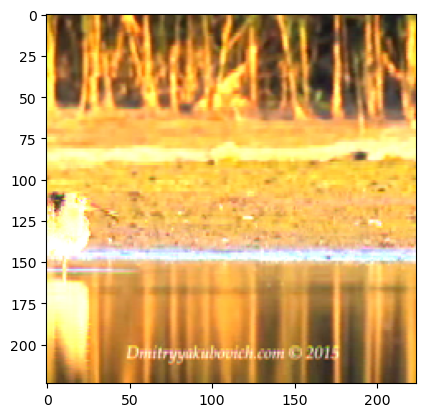

In [8]:
plt.imshow(first_frame.numpy().transpose(1,2,0))

Construct the model:

In [9]:
start_time = time.time() 
i3d = InceptionI3d(400, in_channels=3) # first input is num_classes 
i3d.load_state_dict(torch.load('rgb_imagenet.pt'))
num_classes = len(set(video_labels)) #count unique in labels
i3d.replace_logits(num_classes)
# i3d.cuda()
print(f"time taken: {time.time()-start_time} seconds")

time taken: 0.13218116760253906 seconds


Function to evaluate model performance:

In [10]:
#returns accuracy, f1 score, average f1, and confusion matrix for the data
def eval_metrics(ground_truth, predictions, num_classes):

    #dictionary containing the accuracy, precision, f1, avg f1, and confusion matrix for the data
    f1 = f1_score(y_true=ground_truth, y_pred=predictions, labels=np.arange(num_classes), average=None)
    metrics = {
        "accuracy": accuracy_score(y_true=ground_truth, y_pred=predictions),
        "f1": f1,
        "average f1": np.mean(f1),
        "confusion matrix": confusion_matrix(y_true=ground_truth, y_pred=predictions, labels=np.arange(num_classes)),
        "precision": precision_score(y_true=ground_truth, y_pred=predictions, labels=np.arange(num_classes), average=None)
        }
    
    return metrics

Train:

In [ ]:
# set up gradient descent params
optimizer = optim.SGD(i3d.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0000001) # weight_decay = l2 regularization
lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])

# set up training variables 
epochs = 2 # will need to increase later
tot_loss = 0.0
writer = SummaryWriter("deleteme")
step = 0
num_batches = np.ceil(num_videos/batch_size)

# train
for e in range(epochs):
    batch_num = 1
    start_time = time.time()
    print(f"epoch {e}")
    for data, label in loader:
        data = data #.cuda()
        label = label.squeeze().type(torch.LongTensor) #.cuda()
        num_frames = data.size(2)
        per_frame_logits = i3d(data).mean(2)
        preds = per_frame_logits.detach().numpy().argmax(axis=1) # .cpu() # convert logits into predictions for evaluating accuracy
        
        # calculate and save loss
        loss = F.cross_entropy(per_frame_logits, label) 
        writer.add_scalar("train/loss", loss.item(), step)
        
        # perform gradient descent
        print("zerograd")
        optimizer.zero_grad()
        print("backprop")
        loss.backward()
        print("step")
        optimizer.step() 
        
        print("if")
        # print metrics every one epoch (at the last batch)
        if (batch_num == num_batches):
            metrics = eval_metrics(ground_truth = label.detach().numpy(), # .cpu()
                                   predictions = preds, 
                                   num_classes = num_classes)
            print(f"epoch {e}:")
            print(f"loss: {loss}, accuracy: {round(metrics['accuracy'],2)}, f1 score: {round(metrics['average f1'],2)}")
            print(f"precision: \n{metrics['precision']}")
            print("confusion matrix:")
            print(metrics['confusion matrix']) 
        
        print("update")
        step+=1
        batch_num+=1
        print(f"{batch_num}", end=' ')
        np.savetxt(np.array([e,batch_num]),"progress")
        print("-----------------------------------------------------------------------")
        
    print(f"Time taken for epoch {e}: {(time.time()-start_time)/60} mins")
    print("-----------------------------------------------------------------------")

writer.flush() # ensure that all loss values are recorded 

epoch 0
zerograd
backprop


save model

In [ ]:
model_path = "models/baseline_2epochs_augmented"
torch.save(i3d, model_path)

Check saved output

In [ ]:
torch.load(model_name)

Print final performance

In [ ]:
print(f"epoch {e}:")
print(f"loss: {loss}, accuracy: {round(metrics['accuracy'],2)}, f1 score: {round(metrics['average f1'],2)}")
print(f"precision: \n{metrics['precision']}")
print("confusion matrix:")
print(metrics['confusion matrix']) 